# Semantic change in LatinISE (medical terms)


Barbara McGillivray, Paola Marongiu

This notebook contains the code used for the evaluation of the word embeddings trained on the LatinISE corpus, performed for the Short Term Scientific Mission (STSM) funded by the COST Action “Nexus Linguarum” (CA 18209) and carried out at the King’s College London, under the supervision of Dr. Barbara McGillivray (King’s College London) and Dr. Fahad Khan (CNR-ILC). Grant reference: E-COST-GRANT-CA18209-c61c3227.
The code is from McGillivray, B. & Nowak, K. (2022). Tracing the semantic change of socio-political terms from Classical to early Medieval Latin with computational methods. In Latin vulgaire – latin tardif XIV. 14th International Colloquium on Late and Vulgar Latin. September 5-9, 2022, Ghent University. Book of Abstracts. Ghent University. https://www.lvlt14.ugent.be/wp-content/uploads/2022/09/LVLT14-Book-of-abstracts.pdf (last accessed date: 31/01/2023).

## Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [1]:
!pip install gensim==4.0
!pip install plotly

Import libraries

In [2]:
import os 
#from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd
#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.corpus import stopwords
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from gensim.models import FastText
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import plotly.express as px
import re
from statistics import mean
#from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

/home/paola_user/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


ModuleNotFoundError: No module named 'spacy'

# Parameters

I set the parameters of the analysis.

In [3]:
lemmas_or_tokens = "lemmas" # this can be "lemmas" or "tokens"

## Reading the files

I define the name of the folders:

In [4]:
dir_in = os.path.join("/home", "paola_user", "Scaricati", "LatinISE")
dir_out = os.path.join(dir_in, "semantic_change_output")

I define the list of all files:

In [5]:
files = os.listdir(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens))

How many files are in the folder?


In [6]:
len(files)

1268

We only want IntraText files: (why? because some texts are repeated. add medical texts not in IntraText)

In [7]:
files = [f for f in files[:] if "IT" in f]
len(files)

670

I read the metadata file:

In [8]:
metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")] #we want all the files from IT (one medical text is not among IntraText)
metadata_df = metadata_df[metadata_df['date'] < 1000] #stop at x year
metadata_df

,id,title,creator,date,type,file,medical text
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,lat_0382_IT-LAT0001.txt,0
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,0
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,0
23,IT-LAT0015,Confessiones,"Augustinus, Aurelius",399,prose,lat_0399_IT-LAT0015.txt,0
24,IT-LAT0016,Regula,"Augustinus, Aurelius",391,prose,lat_0391_IT-LAT0016.txt,0
...,...,...,...,...,...,...,...
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_3.txt,0
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_4.txt,0
837,ITMQDQ-247,medicamina faciei,"Ovidius Naso, Publius",30,poetry,lat_+0030_MQDQ-247.txt,1
1221,ITMQDQ-440,liber medicinalis,unknown,350,poetry,lat_0350.0_MQDQ-440.txt,1


Metadata about medical texts 

In [9]:
med_metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
med_metadata_df = med_metadata_df[med_metadata_df['id'].str.startswith("IT")] #we want all the files from IT (one medical text is not among IntraText)
med_metadata_df = med_metadata_df[med_metadata_df['date'] < 600]
med_metadata_df = med_metadata_df[med_metadata_df['medical text'] == 1]
med_metadata_df

,id,title,creator,date,type,file,medical text
221,IT-LAT0382,De medicina,"Celsus, Cornelius Aulus",30,prose,lat_0030_IT-LAT0382.txt,1
562,IT-LAT0895,Medicina ex oleribus et pomis,"Gargilius Martialis, Quintus",260,prose,lat_0260_IT-LAT0895.txt,1
634,IT-LAT0987,De observatione ciborum,Anthimus,550,prose,lat_0550_IT-LAT0987.txt,1
837,ITMQDQ-247,medicamina faciei,"Ovidius Naso, Publius",30,poetry,lat_+0030_MQDQ-247.txt,1
1221,ITMQDQ-440,liber medicinalis,unknown,350,poetry,lat_0350.0_MQDQ-440.txt,1


In [10]:
metadata_df.shape

(394, 7)

In [11]:
metadata_df.columns

Index(['id', 'title', 'creator', 'date', 'type', 'file', 'medical text'], dtype='object')

In [12]:
metadata_df['date'].describe

<bound method NDFrame.describe of 18      382
19       -9
20      524
23      399
24      391
       ... 
685     116
686     116
837      30
1221    350
1265    533
Name: date, Length: 394, dtype: int64>

In [13]:
metadata_df.dtypes

id              object
title           object
creator         object
date             int64
type            object
file            object
medical text     int64
dtype: object

Convert date to integer

In [14]:
metadata_df['date'] = metadata_df['date'].astype(int)
metadata_df.dtypes

id              object
title           object
creator         object
date             int64
type            object
file            object
medical text     int64
dtype: object

In [15]:
metadata_df.head

<bound method NDFrame.head of                 id                   title  \
18      IT-LAT0001                 Vulgata   
19      IT-LAT0537            Ars amatoria   
20      IT-LAT0011     S. Benedicti Regula   
23      IT-LAT0015            Confessiones   
24      IT-LAT0016                  Regula   
...            ...                     ...   
685   IT-LAT0534_3  Dialogus de oratoribus   
686   IT-LAT0534_4               Historiae   
837     ITMQDQ-247       medicamina faciei   
1221    ITMQDQ-440       liber medicinalis   
1265    IT-LAT0202           Institutiones   

                                                creator  date    type  \
18                                           Hieronymus   382  poetry   
19                                Ovidius Naso, Publius    -9  poetry   
20                                 Benedictus Nursianus   524   prose   
23                                 Augustinus, Aurelius   399   prose   
24                                 Augustinus, Aurel

Number of works per year:

In [16]:
metadata_df0 = metadata_df.groupby(['date']).count()
metadata_df0 = metadata_df0['id']
metadata_df0

date
-450    1
-229    1
-199    3
-185    1
-149    2
       ..
 850    4
 871    1
 907    1
 909    1
 950    5
Name: id, Length: 112, dtype: int64

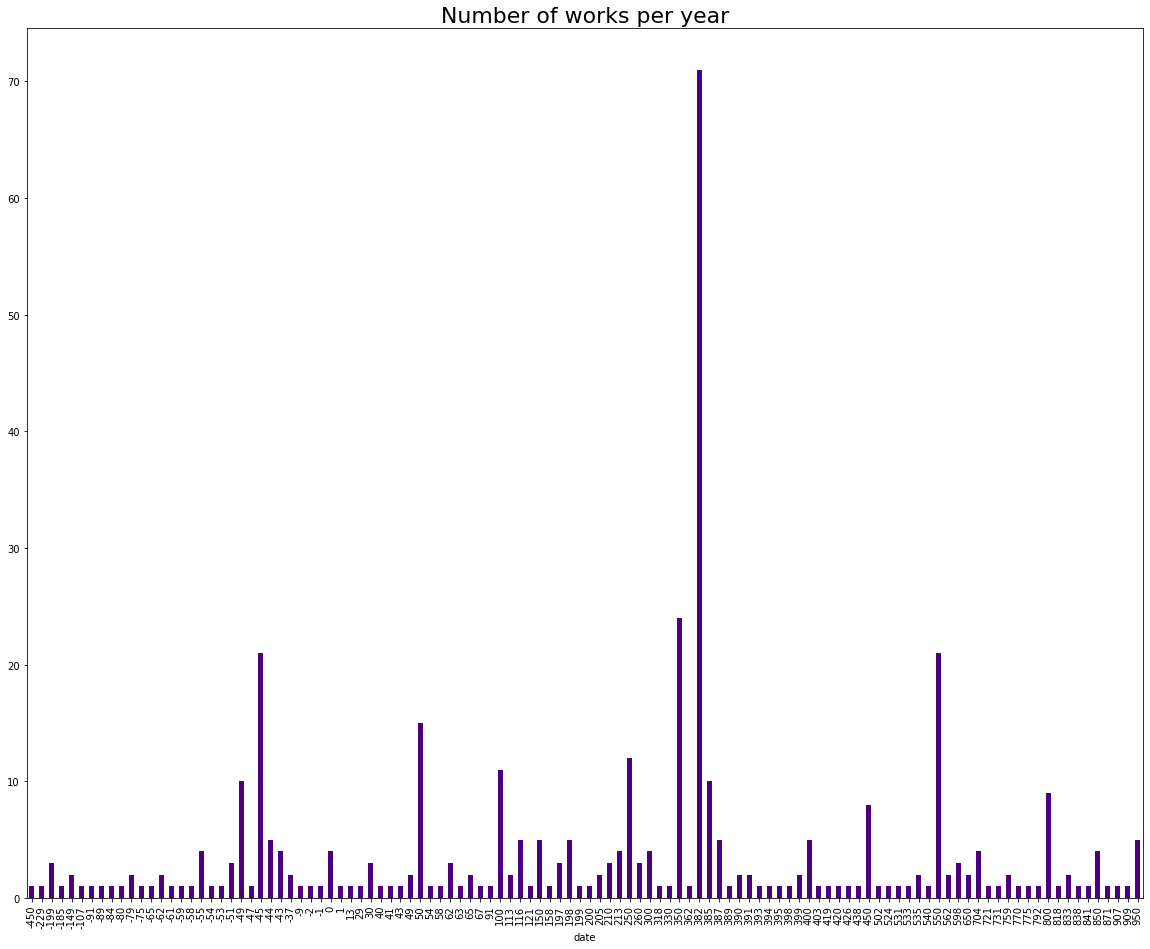

In [17]:
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per year", fontsize=22)
plt.show()

## Split the corpus into subcorpora (medical vs. non medical)

Number of works in medical texts

In [20]:
metadata_df1 = metadata_df.groupby(['medical text']).count()
metadata_df1 = metadata_df1['id']
metadata_df1

medical text
0    389
1      5
Name: id, dtype: int64

Visualise in a barplot

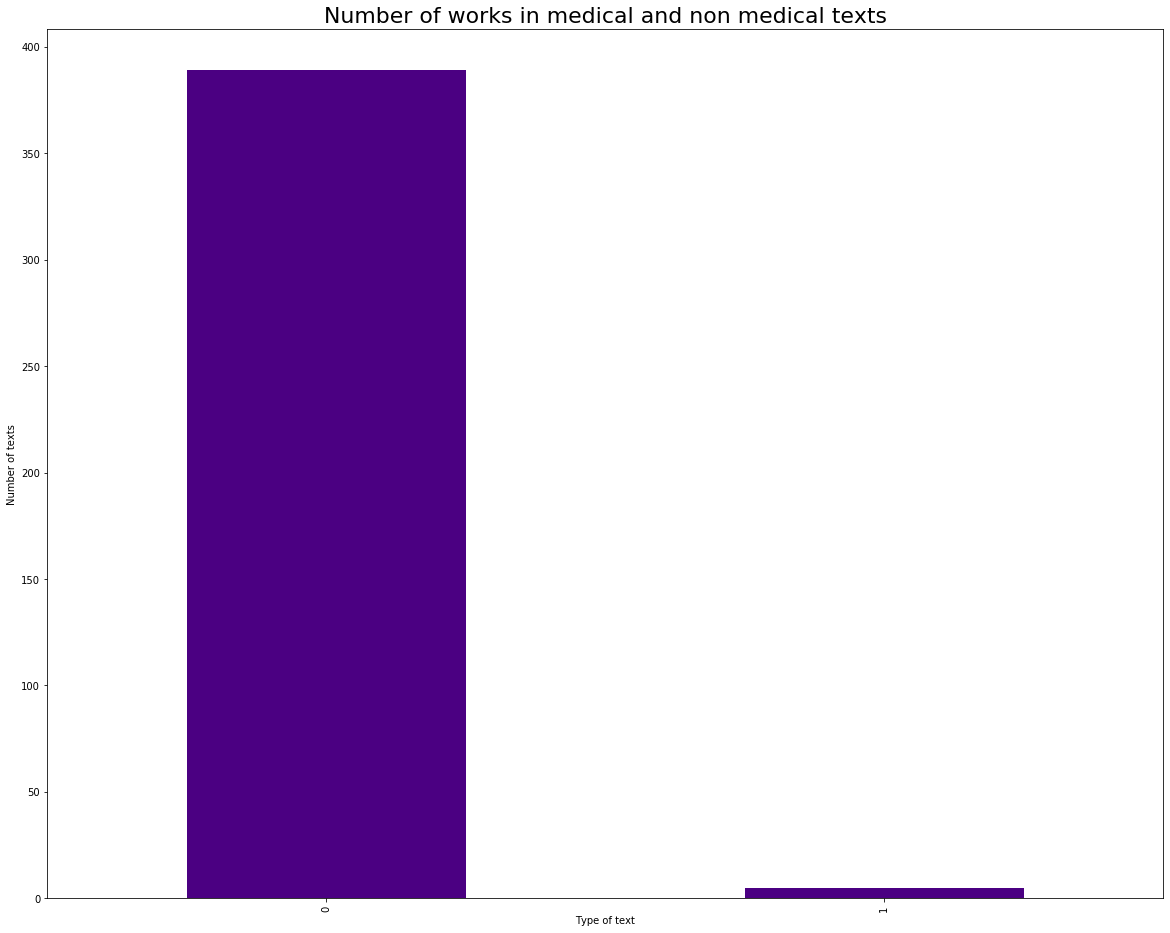

In [22]:
ax = metadata_df1.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works in medical and non medical texts", fontsize=22)
plt.ylabel("Number of texts")
plt.xlabel("Type of text")
plt.show()

Medical and non medical texts

In [20]:
n_subcorpus = metadata_df1
n_subcorpus

medical text
0    389
1      5
Name: id, dtype: int64

In [21]:
len(n_subcorpus)

2

### Count number of tokens in the two subcorpora

In [119]:
metadata_df = pd.read_csv("/home/paola_user/Scaricati/LatinISE/latinise_metadata.csv")

In [120]:
filtered_metadata_df = metadata_df[metadata_df["medical text"] == 1]

In [121]:
medical_ids = filtered_metadata_df['id'].tolist()

In [122]:
print("IDs with 'medical text' value of 1:")
print(medical_ids)

IDs with 'medical text' value of 1:
['IT-LAT0382', 'IT-LAT0895', 'IT-LAT0987', 'IT-MQDQ-247', 'IT-MQDQ-440']


In [123]:
folder_path = "/home/paola_user/Scaricati/LatinISE/preprocessed_tokens"

In [125]:
token_count = 0
for filename in os.listdir(folder_path):
    #print(filename)
    for j in medical_ids:
        if j in filename:
            print(filename, "done")
            with open(os.path.join(folder_path, filename), 'r') as file:
                content = file.read()
                tokens = content.split()
                token_count += len(tokens)
        
        # Output the token count
print(token_count)

lat_0030_IT-LAT0382.txt done
lat_0260_IT-LAT0895.txt done
lat_+0030_IT-MQDQ-247.txt done
lat_0550_IT-LAT0987.txt done
lat_0350.0_IT-MQDQ-440.txt done
142479


In [126]:
filtered_metadata_df = metadata_df[metadata_df["medical text"] == 0]
non_medical_ids = filtered_metadata_df['id'].tolist()
print("IDs with 'medical text' value of 0:")
print(non_medical_ids)

token_count = 0
for filename in os.listdir(folder_path):
    #print(filename)
    for j in non_medical_ids:
        if j in filename:
            #print(filename, "done")
    #if medical_ids_ in filename:
    #if filename.endswith(medical_ids_tuple):
        #print("done")
            with open(os.path.join(folder_path, filename), 'r') as file:
                content = file.read()
                tokens = content.split()
                token_count += len(tokens)
        
        # Output the token count
print(token_count)

IDs with 'medical text' value of 0:
['LC-10', 'LC-11', 'LC-12', 'LC-12_1', 'LC-14', 'LC-14_1', 'LC-16', 'LC-17', 'LC-16_1', 'LC-19', 'LC-1', 'LC-3', 'LC-4', 'LC-5', 'LC-6', 'LC-7', 'LC-8', 'LC-9', 'IT-LAT0001', 'IT-LAT0537', 'IT-LAT0011', 'IT-LAT0012', 'IT-LAT0014', 'IT-LAT0015', 'IT-LAT0016', 'IT-LAT0017', 'IT-LAT0018', 'IT-LAT0021', 'IT-LAT0022', 'IT-LAT0023', 'IT-LAT0024', 'IT-LAT0025', 'IT-LAT0026', 'IT-LAT0027', 'IT-LAT0029', 'IT-LAT0030', 'IT-LAT0031', 'IT-LAT0043', 'IT-LAT0045', 'IT-LAT0047', 'IT-LAT0051', 'IT-LAT0054', 'IT-LAT0056', 'IT-LAT0058', 'IT-LAT0061', 'IT-LAT0062', 'IT-LAT0563', 'IT-LAT0071', 'IT-LAT0072', 'IT-LAT0073', 'IT-LAT0075', 'IT-LAT0078', 'IT-LAT0079', 'IT-LAT0574', 'IT-LAT0083', 'IT-LAT0574_1', 'IT-LAT0574_2', 'IT-LAT0093', 'IT-LAT0094', 'IT-LAT0095', 'IT-LAT0096', 'IT-LAT0097', 'IT-LAT0098', 'IT-LAT0574_3', 'IT-LAT0101', 'IT-LAT0102', 'IT-LAT0574_4', 'IT-LAT0108', 'IT-LAT0109', 'IT-LAT0111', 'IT-LAT0112', 'IT-LAT0114', 'IT-LAT0115', 'IT-LAT0116', 'IT-LAT0574

18363074


## Training embeddings for the whole corpus

Function for printing the vocabulary of a model

In [22]:
def print_vocab(model, top_n = None):
  if model == '':
    print("Empty model!")
  else:
    count = 0
    if top_n is not None:
      for index, word in enumerate(model.wv.index_to_key):
        count+= 1
        if count < top_n:
          print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
    else:
      for index, word in enumerate(model.wv.index_to_key):
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Function that converts dates into the standard format:

In [23]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

#### Stopwords exclusion and further filtering


I exclude punctuation marks:

In [24]:
punctuation = ['.', ',', '...', ';', ':', '?']

I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [25]:
corpus = list()
files_corpus = metadata_df
for index, df_line in files_corpus.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    print("3:",file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus.append(sentences_this_file)

3: lat_0382_IT-LAT0001.txt
3: lat_-009_IT-LAT0537.txt
3: lat_0524_IT-LAT0011.txt
3: lat_0399_IT-LAT0015.txt
3: lat_0391_IT-LAT0016.txt
3: lat_-0049_IT-LAT0029.txt
3: lat_0158_IT-LAT0043.txt
3: lat_0049_IT-LAT0045.txt
3: lat_-0045_IT-LAT0047.txt
3: lat_0050_IT-LAT0051.txt
3: lat_0121_IT-LAT0054.txt
3: lat_-0049_IT-LAT0056.txt
3: lat_0199_IT-LAT0058.txt
3: lat_0387_IT-LAT0061.txt
3: lat_0197_IT-LAT0062.txt
3: lat_0050_IT-LAT0563.txt
3: lat_0062_IT-LAT0071.txt
3: lat_0049_IT-LAT0072.txt
3: lat_0063_IT-LAT0073.txt
3: lat_0000_IT-LAT0075.txt
3: lat_0062_IT-LAT0078.txt
3: lat_0058_IT-LAT0079.txt
3: lat_0385_IT-LAT0574.txt
3: lat_0040_IT-LAT0083.txt
3: lat_0385_IT-LAT0574_1.txt
3: lat_0385_IT-LAT0574_2.txt
3: lat_-0080_IT-LAT0093.txt
3: lat_-0079_IT-LAT0094.txt
3: lat_-0061_IT-LAT0095.txt
3: lat_-0051_IT-LAT0096.txt
3: lat_-0043_IT-LAT0097.txt
3: lat_-0043_IT-LAT0098.txt
3: lat_0385_IT-LAT0574_3.txt
3: lat_-0043_IT-LAT0101.txt
3: lat_0000_IT-LAT0102.txt
3: lat_0385_IT-LAT0574_4.txt
3: lat_-00

3: lat_0050_IT-LAT0868.txt
3: lat_0300_IT-LAT0873.txt
3: lat_0550_IT-LAT0875.txt
3: lat_0400_IT-LAT0878.txt
3: lat_0400_IT-LAT0880.txt
3: lat_0030_IT-LAT0883.txt
3: lat_0330_IT-LAT0886.txt
3: lat_0841_IT-LAT0888.txt
3: lat_0907_IT-LAT0891.txt
3: lat_0260_IT-LAT0893.txt
3: lat_0260_IT-LAT0895.txt
3: lat_0260_IT-LAT0896.txt
3: lat_0450_IT-LAT0904.txt
3: lat_0550_IT-LAT0906.txt
3: lat_0770_IT-LAT0907.txt
3: lat_0598_IT-LAT0908.txt
3: lat_0598_IT-LAT0909.txt
3: lat_0800_IT-LAT0911_7.txt
3: lat_0250_IT-LAT0913.txt
3: lat_0250_IT-LAT0914.txt
3: lat_0150_IT-LAT0916.txt
3: lat_0502_IT-LAT0917.txt
3: lat_0350_IT-LAT0919.txt
3: lat_0850_IT-LAT0920.txt
3: lat_0731_IT-LAT0921.txt
3: lat_-0045_IT-LAT0922_16.txt
3: lat_0067_IT-LAT0934.txt
3: lat_0833_IT-LAT0936.txt
3: lat_-0185_IT-LAT0952.txt
3: lat_-0044_IT-LAT0955.txt
3: lat_-0044_IT-LAT0956.txt
3: lat_0598_IT-LAT0957.txt
3: lat_0250_IT-LAT0959.txt
3: lat_0350_IT-LAT0978.txt
3: lat_0950_IT-LAT0980.txt
3: lat_0550_IT-LAT0987.txt
3: lat_-0149_IT-LAT

FileNotFoundError: [Errno 2] No such file or directory: '/home/paola_user/Scaricati/LatinISE/preprocessed_lemmas/lat_0030_ITMQDQ-247.txt'

In [ ]:
metadata_df

In [ ]:
corpus

In [26]:
len(corpus)

318576

Function for training FastText models (from Krzysztof Nowak):

In [27]:
def fasttext(self, opts=dict()):
        """
        Reads sentences from the corpus. Implements:
            https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText
        Returns
        -------
        FastText model
        """
        default_opts = dict(vector_size=100, alpha=0.025,
                            window=5, min_count=5, epochs=5)
        opts_new = default_opts
        for opt in opts.keys():
            opts_new[opt] = opts[opt]
        model = FastText(
            vector_size=opts_new["vector_size"],
            alpha=opts_new["alpha"],
            window=opts_new["window"],
            min_count=opts_new["min_count"])
        model.build_vocab(corpus_iterable=[sentence for sentence in
                                           self.corpus.get_sents()])
        total_examples = model.corpus_count
        model.train(corpus_iterable=[sentence for sentence
                                     in self.corpus.get_sents()],
                    total_examples=total_examples,
                    epochs=opts_new["epochs"])
        return model

Parameters: 

`min_count`: the minimum frequency threshold allowed for a word to be included; set to 3 following Ribary & McGillivray (2020) or 5 following Sprugnoli et al. (2019).

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000. Set to 100 following Ribary & McGillivray (2020).

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10. Set to 10 following Sprugnoli et al. (2020).

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW. Set to 10 following Ribary & McGillivray (2020).


Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [29]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=5, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

KeyboardInterrupt: 

## Test with "causa" on the whole corpus (both a general term and specialised term in medical Latin)

#### First test: Minimal frequency = 5 (check for lower frequency words) and vector size = 100

Let's see what words are similar to "causa":

In [79]:
model.wv.similar_by_word('causa', 10)

[('causo', 0.8693389296531677),
 ('caussa', 0.8572415113449097),
 ('causatio', 0.828999936580658),
 ('causor', 0.8153892755508423),
 ('causalis', 0.8007003664970398),
 ('causarius', 0.7590205073356628),
 ('musa', 0.7423707842826843),
 ('causaque', 0.7420263886451721),
 ('Susa', 0.7409977912902832),
 ('causamque', 0.7246591448783875)]

#### Test 2: Adding max_n=0 and min_n=0 to avoid selection at the string level (turn off subwords), keep the other parameters steady

In [90]:
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, max_n = 0, min_n = 0)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(21226940, 26628620)

Try again with "causa": results are better. The direct synonym of "causa" in the gold standard Sprugnoli et al. 2020 is "ratio", which still does not appear here

In [91]:
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('potio', 10)

It has taken 99 seconds


[('potus', 0.7746923565864563),
 ('cibus', 0.7582693099975586),
 ('alimentum', 0.6682046055793762),
 ('extenuo', 0.6668452024459839),
 ('concoquo', 0.6660478711128235),
 ('medicamentum', 0.658385157585144),
 ('sitis', 0.6566506028175354),
 ('esca', 0.6549215912818909),
 ('febrem', 0.6542739272117615),
 ('pabulum', 0.6541865468025208)]

#### Test 3: Turn off subwords, raise minimal frequency to 50, vector size 100

In [92]:
start = time.time()
model = FastText(vector_size=100, window=10, min_count=50, workers=1, seed=1, hashfxn=hash, max_n = 0, min_n = 0)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(19500429, 26628620)

Try again with "causa"

In [93]:
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('potio', 10)

It has taken 70 seconds


[('cibus', 0.7652978301048279),
 ('esca', 0.713490903377533),
 ('potus', 0.7071375846862793),
 ('sitis', 0.6719212532043457),
 ('incresco', 0.666099488735199),
 ('alimentum', 0.6642388701438904),
 ('stomachus', 0.6602162718772888),
 ('sitio', 0.6561112999916077),
 ('alvus', 0.6513990163803101),
 ('frigidus', 0.6403871774673462)]

I experiment with two equivalent ways to train a Fast Text model:

In [41]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.corpus_count
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(33210810, 44714280)

In [103]:
model2 = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash, 
                  sentences=corpus)
model2.corpus_count

523039

In [ ]:
np.allclose(model.wv['dies'], model2.wv['dies'])

The models has a vocabulary of

In [ ]:
model.corpus_total_words

words and 

In [ ]:
model.corpus_count

sentences.

I evaluate different configurations of the parameters for the embeddings against the gold standard set by Sprugnoli et al. (2019) (https://github.com/CIRCSE/Lemma-Embeddings-for-Latin/blob/master/syn-selection-benchmark-Latin.tsv) to find the best configuration of parameters:

https://gitlab.surrey.ac.uk/mr0048/pydigest/-/blob/master/script/fasttext_003.py

WE MAY ALSO WANT TO EVALUATE THE TIME-INSENSITIVE EMBEDDINGS (i.e. trained of the full corpus) similarly to Ribary & McGillivray (2020)

## Training embeddings for each subcorpus


For each subcorpus (medical and non medical texts), I read the texts from files and create a list of lists, i.e. a list of sentences:

In [28]:
# dictionary that maps a subcorpus with the list of sentences of texts in that subcorpus"
subcorpus2corpus = dict()
subcorpus = [0, 1]

# I loop over both subcorpora (medical and non medical):
for s in range(len(subcorpus)):
    print('domain:', subcorpus[s])
    files_corpus_s = metadata_df.loc[metadata_df['medical text'] == subcorpus[s]]
    print(files_corpus_s)
    #print("1:",files_corpus_s, type(files_corpus_s))
    corpus_s = list()
    for index, df_line in files_corpus_s.iterrows():
        print("line:", df_line['id'], df_line['medical text'])
        count = 0
        for filename in files:
            count = count + 1
            if df_line['id'] in filename and df_line['medical text'] == subcorpus[s]:# and count<10:
                print(df_line['medical text'], "file!", filename)
                file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, filename), 'r')
                sentences_this_file = list()
                while True:
                    line = file.readline().strip()
                    #print(line[1:50])
                    if line != "":
                        corpus_s.append([token for token in line.split(" ") if token not in punctuation])
                    if not line:
                        break
                file.close()
    subcorpus2corpus[s] = corpus_s
   #     sign = "+"
        #print(df_line['date'])
   #     if df_line['date'] < 0:
   #         sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
   #     file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
   #     file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
   #     sentences_this_file = list()
   #     while True:
   #         line = file.readline().strip()
   #         if line != "":
                #sentences_this_file.append(line.split(" "))
                #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
   #             corpus_t.append([token for token in line.split(" ") if token not in punctuation])
            # if line is empty end of file is reached
   #         if not line:
   #             break
   #     file.close()
        #corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
   # time2corpus[t] = corpus_t


domain: 0
                id                          title  \
18      IT-LAT0001                        Vulgata   
19      IT-LAT0537                   Ars amatoria   
20      IT-LAT0011            S. Benedicti Regula   
23      IT-LAT0015                   Confessiones   
24      IT-LAT0016                         Regula   
...            ...                            ...   
683   IT-LAT0534_1  De origine et situ Germanorum   
684   IT-LAT0534_2        De vita Iulii Agricolae   
685   IT-LAT0534_3         Dialogus de oratoribus   
686   IT-LAT0534_4                      Historiae   
1265    IT-LAT0202                  Institutiones   

                                                creator  date    type  \
18                                           Hieronymus   382  poetry   
19                                Ovidius Naso, Publius    -9  poetry   
20                                 Benedictus Nursianus   524   prose   
23                                 Augustinus, Aurelius   399

line: IT-LAT0136 0
0 file! lat_-0053_IT-LAT0136.txt
line: IT-LAT0137 0
0 file! lat_-0054_IT-LAT0137.txt
line: IT-LAT0138 0
0 file! lat_-0045_IT-LAT0138.txt
line: IT-LAT0139 0
0 file! lat_-0045_IT-LAT0139.txt
line: IT-LAT0140 0
0 file! lat_-0044_IT-LAT0140.txt
line: IT-LAT0574_8 0
0 file! lat_0385_IT-LAT0574_8.txt
line: IT-LAT0142 0
0 file! lat_-001_IT-LAT0142.txt
line: IT-LAT0148 0
0 file! lat_0029_IT-LAT0148.txt
line: IT-LAT0574_9 0
0 file! lat_0385_IT-LAT0574_9.txt
line: IT-LAT0588 0
0 file! lat_0050_IT-LAT0588.txt
0 file! lat_0050_IT-LAT0588_1.txt
0 file! lat_0050_IT-LAT0588_2.txt
line: IT-LAT0588_1 0
0 file! lat_0050_IT-LAT0588_1.txt
line: IT-LAT0911 0
0 file! lat_0800_IT-LAT0911_4.txt
0 file! lat_0800_IT-LAT0911_3.txt
0 file! lat_0800_IT-LAT0911_2.txt
0 file! lat_0800_IT-LAT0911_5.txt
0 file! lat_0800_IT-LAT0911.txt
0 file! lat_0800_IT-LAT0911_6.txt
0 file! lat_0800_IT-LAT0911_7.txt
0 file! lat_0800_IT-LAT0911_1.txt
line: IT-LAT0155 0
0 file! lat_-0043_IT-LAT0155.txt
line: IT-LAT0

line: IT-LAT0403 0
0 file! lat_0399_IT-LAT0403.txt
line: IT-LAT0405 0
0 file! lat_-0199_IT-LAT0405.txt
line: IT-LAT0406 0
0 file! lat_0150_IT-LAT0406.txt
line: IT-LAT0407 0
0 file! lat_0150_IT-LAT0407.txt
line: IT-LAT0990_5 0
0 file! lat_0550_IT-LAT0990_5.txt
line: IT-LAT0410 0
0 file! lat_0403_IT-LAT0410.txt
line: IT-LAT0413 0
0 file! lat_0250_IT-LAT0413.txt
line: IT-LAT0414 0
0 file! lat_0450_IT-LAT0414.txt
line: IT-LAT0990_6 0
0 file! lat_0550_IT-LAT0990_6.txt
line: IT-LAT0419 0
0 file! lat_0704_IT-LAT0419.txt
line: IT-LAT0420 0
0 file! lat_0704_IT-LAT0420.txt
line: IT-LAT0421 0
0 file! lat_0704_IT-LAT0421.txt
line: IT-LAT0422 0
0 file! lat_0704_IT-LAT0422.txt
line: IT-LAT0423 0
0 file! lat_0721_IT-LAT0423.txt
line: IT-LAT0425 0
0 file! lat_0050_IT-LAT0425.txt
line: IT-LAT0429 0
0 file! lat_0550_IT-LAT0429.txt
line: IT-LAT0431 0
0 file! lat_0550_IT-LAT0431.txt
line: IT-LAT0433 0
0 file! lat_0550_IT-LAT0433.txt
line: IT-LAT0435 0
0 file! lat_0550_IT-LAT0435.txt
line: IT-LAT0448 0
0 f

0 file! lat_0531_IT-LAT0867.txt
line: IT-LAT0868 0
0 file! lat_0050_IT-LAT0868.txt
line: IT-LAT0873 0
0 file! lat_0300_IT-LAT0873.txt
line: IT-LAT0875 0
0 file! lat_0550_IT-LAT0875.txt
line: IT-LAT0878 0
0 file! lat_0400_IT-LAT0878.txt
line: IT-LAT0880 0
0 file! lat_0400_IT-LAT0880.txt
line: IT-LAT0883 0
0 file! lat_0030_IT-LAT0883.txt
line: IT-LAT0886 0
0 file! lat_0330_IT-LAT0886.txt
line: IT-LAT0888 0
0 file! lat_0841_IT-LAT0888.txt
line: IT-LAT0891 0
0 file! lat_0907_IT-LAT0891.txt
line: IT-LAT0893 0
0 file! lat_0260_IT-LAT0893.txt
line: IT-LAT0896 0
0 file! lat_0260_IT-LAT0896.txt
line: IT-LAT0904 0
0 file! lat_0450_IT-LAT0904.txt
line: IT-LAT0906 0
0 file! lat_0550_IT-LAT0906.txt
line: IT-LAT0907 0
0 file! lat_0770_IT-LAT0907.txt
line: IT-LAT0908 0
0 file! lat_0598_IT-LAT0908.txt
line: IT-LAT0909 0
0 file! lat_0598_IT-LAT0909.txt
line: IT-LAT0911_7 0
0 file! lat_0800_IT-LAT0911_7.txt
line: IT-LAT0913 0
0 file! lat_0250_IT-LAT0913.txt
line: IT-LAT0914 0
0 file! lat_0250_IT-LAT0914

Let's inspect the corpus for the first time interval:

In [29]:
subcorpus2corpus[0]

[['frater', 'quis#2', 'sum', 'per', 'Aegyptus', 'Iudaei', 'salus', 'dico#2'],
 ['frater',
  'quis#2',
  'sum',
  'in',
  'Hierosolyma',
  'Iudaei',
  'et',
  'quis#2',
  'in',
  'regio'],
 ['Iudaea', 'et', 'pax', 'bonus'],
 ['benefacio',
  'vos',
  'deus',
  'et',
  'memini',
  'testamentum',
  'suus',
  'quod',
  'sum'],
 ['ad', 'Abraham', 'et', 'Isaac', 'et', 'Iacob', 'servus', 'suus', 'fidelis'],
 ['et', 'do', 'vos', 'cor', 'omnis', 'ut', 'colo', 'is', 'et', 'facio', 'is'],
 ['voluntas', 'cor', 'magnus', 'et', 'animus', 'volente'],
 ['adaperio',
  'cor',
  'vos',
  'in',
  'lex',
  'suus',
  'et',
  'in',
  'praeceptum',
  'is',
  'et'],
 ['facio', 'pax'],
 ['exaudio', 'oratio', 'vester', 'et', 'reconcilio', 'vos', 'nec', 'vos'],
 ['desero', 'in', 'tempus', 'malus'],
 ['et', 'nunc', 'hic', 'sum', 'oro', 'pro', 'vos'],
 ['regno',
  'Demetrium',
  'annus',
  'centesimus',
  'sexagesimus',
  'nonus',
  'nos',
  'Iudaei'],
 ['scribo',
  'vos',
  'in',
  'tribulatio',
  'et',
  'impetus'

And the second:

In [30]:
subcorpus2corpus[1]

[['ut',
  'alimentum',
  'sanus',
  'corpus',
  'agricultura',
  'sic',
  'sanitas',
  'aegrum',
  'medicinus',
  'promitto'],
 ['hic',
  'nusquam',
  'quidem',
  'non',
  'sum',
  'siquidem',
  'etiam',
  'inperitissimae',
  'gens',
  'herba',
  'aliaque',
  'promta',
  'in',
  'auxilium',
  'vulnus',
  'morborumque',
  'nosco'],
 ['verus',
  'tamen',
  'apud',
  'Graecus',
  'aliquantus',
  'magis',
  'quam#4',
  'in',
  'ceterus',
  'natio',
  'excolo',
  'sum',
  'atque',
  'ne#2',
  'apud',
  'hic',
  'quidem',
  'ab',
  'primus',
  'origo',
  'sed',
  'paucus',
  'ante',
  'nos',
  'saeculum'],
 ['ut',
  'pote',
  'cum',
  'vetustus',
  'auctor',
  'Aesculapius',
  'celebro',
  'quis#2',
  'quoniam',
  'adhuc',
  'rudis',
  'et',
  'vulgaris',
  'hic',
  'scientia',
  'paulum',
  'subtilis',
  'excoluit',
  'in',
  'deus',
  'numerus',
  'recipio',
  'sum'],
 ['hic',
  'deinde',
  'duo',
  'filius',
  'Podalirius',
  'et',
  'Machaon',
  'bellum',
  'Troiano',
  'dux',
  'Agamemn

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each subcorpus I train a fasttext model:

Start with the first subcorpus:
Barbara: "The corpus is small and the fasttext seems to prefer orthographic similarity with smaller min_counts. We're not interested in dies being similar to rabies, but rather dies being similar to annus or mensis. So, we have two options: we may either turn off the subwords or apply high frequency threshold (but we're going to loose low-frequency terms)"

Try excluding subwords and setting minimal frequency to 5 (see experiment on embeddings for the full corpus with "causa": ideal combination of parameters is max_n=0, min_n=0, min_count=5

In [31]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, min_n=0, max_n=0)
model.build_vocab(corpus_iterable=subcorpus2corpus[0])
model.train(corpus_iterable=subcorpus2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('causa', 10)

KeyboardInterrupt: 

In [37]:
print_vocab(model, 10)

word #0/33583 is et
word #1/33583 is sum
word #2/33583 is in
word #3/33583 is quis#2
word #4/33583 is is
word #5/33583 is non
word #6/33583 is hic
word #7/33583 is ad
word #8/33583 is ut


Another test with "sum"

In [38]:
model.wv.similar_by_word('sum', 10)

[('appareo', 0.5292460918426514),
 ('habeo', 0.517448902130127),
 ('existo', 0.5027661919593811),
 ('invenio', 0.48599913716316223),
 ('permaneo', 0.4838952422142029),
 ('iudico', 0.48345261812210083),
 ('indigeo', 0.48066267371177673),
 ('contingo', 0.4800867736339569),
 ('praecedo', 0.467045396566391),
 ('nasco', 0.46400588750839233)]

Additionally, we could set a higher frequency threshold, but that we would lose low-frequency terms: with minimal frequency = 50

In [166]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0) 
model.build_vocab(corpus_iterable=subcorpus2corpus[0])
model.train(corpus_iterable=subcorpus2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('causa', 10)

It has taken 66 seconds


[('lite', 0.6106802225112915),
 ('accusatio', 0.6002997159957886),
 ('disceptatio', 0.5790320038795471),
 ('ratio', 0.5747724771499634),
 ('defensio', 0.5611129403114319),
 ('deliberatio', 0.5604794025421143),
 ('probatio', 0.5601478815078735),
 ('quaestio', 0.5547122955322266),
 ('culpa', 0.5457818508148193),
 ('crimen', 0.5342454314231873)]

### Train one model for each subcorpus
I now train one model for each subcorpus (medical vs. non medical): set minimal frequency 5 and exclude subwords

In [32]:
len(subcorpus2corpus)

2

In [33]:
models = list()
start = time.time()
for s in range(len(subcorpus2corpus)):
    if len(subcorpus2corpus[s])>0:
        print(s)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, max_n=0, min_n=0)  # instantiate
        model.build_vocab(corpus_iterable=subcorpus2corpus[s])
        model.train(corpus_iterable=subcorpus2corpus[s], total_examples=len(subcorpus2corpus[s]), epochs=10)  # train
        models.append(model)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

0
1
It has taken 198 seconds, or  3 minutes


Check on the two models

In [41]:
print_vocab(models[0], 20)

word #0/33583 is et
word #1/33583 is sum
word #2/33583 is in
word #3/33583 is quis#2
word #4/33583 is is
word #5/33583 is non
word #6/33583 is hic
word #7/33583 is ad
word #8/33583 is ut
word #9/33583 is ab
word #10/33583 is cum
word #11/33583 is ille
word #12/33583 is omnis
word #13/33583 is dico#2
word #14/33583 is quod
word #15/33583 is suus
word #16/33583 is de
word #17/33583 is si
word #18/33583 is ego


## Check malus

In [42]:
models[0].wv.similar_by_word('malus', 10)

[('malus#3', 0.7445393800735474),
 ('deterior', 0.6224241256713867),
 ('publicatio', 0.550349771976471),
 ('conscientia', 0.5132147073745728),
 ('fraudis', 0.503659725189209),
 ('invidus', 0.5022456645965576),
 ('malignitas', 0.48834073543548584),
 ('nequitia', 0.48028719425201416),
 ('malitia', 0.47844555974006653),
 ('pessimi', 0.4778210520744324)]

In [43]:
print_vocab(models[1], 20)

word #0/2122 is sum
word #1/2122 is et
word #2/2122 is is
word #3/2122 is in
word #4/2122 is quis#2
word #5/2122 is si
word #6/2122 is ex
word #7/2122 is hic
word #8/2122 is vel
word #9/2122 is non
word #10/2122 is aut
word #11/2122 is quod
word #12/2122 is ut
word #13/2122 is cum
word #14/2122 is ad
word #15/2122 is ab
word #16/2122 is quoque
word #17/2122 is sed
word #18/2122 is etiam


In [44]:
models[1].wv.similar_by_word('malus', 10)

[('difficultas', 0.9630550742149353),
 ('articulus', 0.9567130208015442),
 ('consuesco', 0.9554041624069214),
 ('male', 0.9552204012870789),
 ('urina', 0.9537398219108582),
 ('voluntas', 0.9534554481506348),
 ('spes', 0.9531292915344238),
 ('sensus', 0.9526328444480896),
 ('insania', 0.9525879621505737),
 ('vesica', 0.9525068998336792)]

## Check potio

In [45]:
models[0].wv.similar_by_word('potio', 10)

[('potus', 0.596651554107666),
 ('sopio', 0.5308095216751099),
 ('quies', 0.5303115844726562),
 ('medicamentum', 0.5270382165908813),
 ('cibus', 0.5206639766693115),
 ('satio', 0.515001654624939),
 ('potionis', 0.5114859342575073),
 ('somnoque', 0.5112212896347046),
 ('haurio', 0.5046415328979492),
 ('adlici', 0.4984215795993805)]

In [46]:
models[1].wv.similar_by_word('potio', 10)

[('utor', 0.9829772114753723),
 ('abstineo', 0.9741743803024292),
 ('pridie', 0.9734511971473694),
 ('uti', 0.9712179899215698),
 ('egelidus', 0.9695520401000977),
 ('adsumo', 0.9688200354576111),
 ('acer', 0.9610457420349121),
 ('sumo', 0.9605630040168762),
 ('modicus', 0.9598569869995117),
 ('debeo', 0.9592777490615845)]

## Check lenticula

In [47]:
models[0].wv.similar_by_word('lenticula', 10)

[('perunges', 0.8608763813972473),
 ('asperso', 0.8605087995529175),
 ('cyperum', 0.8578701019287109),
 ('defritum', 0.8502394556999207),
 ('porrus', 0.8457130789756775),
 ('anethum', 0.8446499109268188),
 ('puleium', 0.8427358269691467),
 ('asperges', 0.841949999332428),
 ('silfi', 0.8419413566589355),
 ('pisum', 0.8400180339813232)]

In [48]:
models[1].wv.similar_by_word('lenticula', 10)

[('lac', 0.9950354695320129),
 ('ruta', 0.9947835803031921),
 ('olea', 0.99403315782547),
 ('marrubium', 0.9940274357795715),
 ('rubus', 0.9916974902153015),
 ('adjicio', 0.9916856288909912),
 ('sucidus', 0.9906005263328552),
 ('malicorium', 0.9898480772972107),
 ('farina', 0.9896025061607361),
 ('furfur', 0.9895826578140259)]

## Check Impetus

In [50]:
models[0].wv.similar_by_word('impetus', 10)

[('eruptio', 0.718285858631134),
 ('incursus', 0.6353676319122314),
 ('concursus', 0.6190795302391052),
 ('acriter', 0.5763891339302063),
 ('concito', 0.5652066469192505),
 ('uiribus', 0.560851514339447),
 ('pavor', 0.5604428648948669),
 ('perrumpo', 0.559894323348999),
 ('inpetu', 0.5539030432701111),
 ('rabies', 0.5501555800437927)]

In [51]:
models[1].wv.similar_by_word('impetus', 10)

[('scroto', 0.997705340385437),
 ('iacio', 0.9975391626358032),
 ('inbecillitas', 0.9973631501197815),
 ('mature', 0.9973325133323669),
 ('mano', 0.9972262382507324),
 ('numquam', 0.9970070719718933),
 ('aliquando', 0.9968353509902954),
 ('vaco', 0.996812105178833),
 ('muto', 0.9967483878135681),
 ('totus', 0.9967460632324219)]

## Check Plaga

In [52]:
models[0].wv.similar_by_word('plaga', 10)

[('contritio', 0.49932730197906494),
 ('septentrionalis', 0.47354528307914734),
 ('aquilo', 0.4706868827342987),
 ('pessima', 0.4643608033657074),
 ('septentrionem', 0.4558558166027069),
 ('meridies', 0.4414684474468231),
 ('desolo', 0.43876615166664124),
 ('serpens', 0.43028056621551514),
 ('languor', 0.43025338649749756),
 ('sibilo', 0.4296463131904602)]

In [53]:
models[1].wv.similar_by_word('plaga', 10)

[('crus', 0.9959562420845032),
 ('ibi', 0.994205892086029),
 ('scalpellum', 0.9938284158706665),
 ('extendo', 0.9937617182731628),
 ('descendo', 0.9934535622596741),
 ('excidium', 0.993284285068512),
 ('ergo', 0.9932499527931213),
 ('proximus', 0.9931142330169678),
 ('integer', 0.9930745363235474),
 ('iacio', 0.9929271936416626)]

## Check anus

In [54]:
models[0].wv.similar_by_word('anus', 10)

[('formosus', 0.7208097577095032),
 ('nutrico', 0.7165568470954895),
 ('delicatus', 0.6415420770645142),
 ('mamma', 0.6402621269226074),
 ('virguncula', 0.6257895827293396),
 ('nutrix', 0.6114704012870789),
 ('Sabina', 0.6049647331237793),
 ('lacto', 0.5958934426307678),
 ('puella', 0.5957138538360596),
 ('thalamus', 0.5906150341033936)]

In [55]:
models[1].wv.similar_by_word('anus', 10)

[('maxilla', 0.9982499480247498),
 ('inguen', 0.9979749917984009),
 ('iuxta', 0.9974749088287354),
 ('ferramentum', 0.9971880912780762),
 ('scrotum', 0.9971383213996887),
 ('antequam', 0.9969991445541382),
 ('vinculum', 0.9969804883003235),
 ('glutino', 0.9967426061630249),
 ('sedeo', 0.9965815544128418),
 ('vulnero', 0.9965251684188843)]

## Check Aranea

In [56]:
models[0].wv.similar_by_word('aranea', 10)

[('pharetra', 0.6134344339370728),
 ('vibro', 0.6050527095794678),
 ('transfigo', 0.6030136346817017),
 ('sulpur', 0.5997458696365356),
 ('hastile', 0.5971342325210571),
 ('texentium', 0.5743292570114136),
 ('stipula', 0.5697602033615112),
 ('ferrum', 0.5689342617988586),
 ('liciatorium', 0.5648847818374634),
 ('spiculus', 0.5626999139785767)]

In [57]:
models[1].wv.similar_by_word('aranea', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Check Cancer

In [58]:
models[0].wv.similar_by_word('cancer', 10)

[('aequinoctialis', 0.7350070476531982),
 ('Capricornus', 0.7211254239082336),
 ('lune', 0.7174912691116333),
 ('Chelis', 0.7116904854774475),
 ('exortus', 0.7026336193084717),
 ('Orion', 0.6997062563896179),
 ('Hydrae', 0.696772038936615),
 ('Cancri', 0.6959371566772461),
 ('brumalis', 0.676031231880188),
 ('exoriri', 0.6754188537597656)]

In [59]:
models[1].wv.similar_by_word('cancer', 10)

[('perniciosus', 0.9970979690551758),
 ('muto', 0.9970343112945557),
 ('abscido', 0.9969481825828552),
 ('animal', 0.9968684315681458),
 ('vetustas', 0.9966973066329956),
 ('afficio', 0.9966148734092712),
 ('occupo', 0.9965019226074219),
 ('desum', 0.9964045882225037),
 ('vinculum', 0.9962295889854431),
 ('caelum', 0.9959255456924438)]

## Check Caninus

In [36]:
models[0].wv.similar_by_word('caninus', 10)

[('palo', 0.7080064415931702),
 ('palustrem', 0.7017350196838379),
 ('unctus', 0.6942863464355469),
 ('sucidus', 0.6911542415618896),
 ('pampinus', 0.6911504864692688),
 ('myrteum', 0.6873365044593811),
 ('caedito', 0.686789333820343),
 ('refoveo', 0.686775803565979),
 ('Arsa', 0.6860144138336182),
 ('balsamum', 0.6847855448722839)]

In [37]:
models[1].wv.similar_by_word('caninus', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Colis

In [40]:
models[0].wv.similar_by_word('caulis', 10)

[('baiulum', 0.0),
 ('vicissimque', 0.0),
 ('auferendo', 0.0),
 ('turbavere', 0.0),
 ('deprecarentur', 0.0),
 ('Parmenion', 0.0),
 ('potentum', 0.0),
 ('destructor', 0.0),
 ('osteum', 0.0),
 ('Clausus', 0.0)]

In [41]:
models[1].wv.similar_by_word('caulis', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Fistula

In [42]:
models[0].wv.similar_by_word('fistula', 10)

[('vicenum', 0.7571058869361877),
 ('centenum', 0.727862536907196),
 ('modulus', 0.7275359630584717),
 ('diametrum', 0.7077943682670593),
 ('plumbea', 0.7031548023223877),
 ('vicenarius', 0.6905785799026489),
 ('semuncia', 0.6882086992263794),
 ('pertundito', 0.6747350692749023),
 ('crocus', 0.6727489829063416),
 ('quadratus', 0.6727017164230347)]

In [43]:
models[1].wv.similar_by_word('fistula', 10)

[('abscido', 0.9949777722358704),
 ('patefacio', 0.9944912195205688),
 ('membrana', 0.994250476360321),
 ('vinculum', 0.9940910935401917),
 ('cancer', 0.9940453171730042),
 ('rumpo', 0.9939383268356323),
 ('naturalis', 0.9937660694122314),
 ('quicumque', 0.9937065243721008),
 ('talus', 0.9936233758926392),
 ('ala', 0.9935315847396851)]

## Folliculus

In [44]:
models[0].wv.similar_by_word('folliculus', 10)

[('pampinus', 0.8198416829109192),
 ('pineum', 0.8055068850517273),
 ('furfur', 0.8008548617362976),
 ('citrum', 0.796357274055481),
 ('callosus', 0.7912360429763794),
 ('lupinus', 0.7903788089752197),
 ('ficos', 0.787680983543396),
 ('sucidus', 0.7866107821464539),
 ('ulmeus', 0.7819167375564575),
 ('damascena', 0.78098064661026)]

In [45]:
models[1].wv.similar_by_word('folliculus', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Lumen

In [46]:
models[0].wv.similar_by_word('lumen', 10)

[('fulgor', 0.7066628932952881),
 ('lux', 0.6773566603660583),
 ('lucidus', 0.6475052237510681),
 ('radius', 0.6295573115348816),
 ('candor', 0.6255735754966736),
 ('caligo', 0.6172627210617065),
 ('luceo', 0.592840313911438),
 ('inlumino', 0.5927273035049438),
 ('splendor', 0.5899431109428406),
 ('caliginem', 0.5879647135734558)]

In [47]:
models[1].wv.similar_by_word('lumen', 10)

[('expeditus', 0.9964432120323181),
 ('plerumque', 0.9961612224578857),
 ('paene', 0.9961373805999756),
 ('restituo', 0.9958831667900085),
 ('curiosus', 0.9958614706993103),
 ('infans', 0.9958545565605164),
 ('capillus', 0.9958263635635376),
 ('adversus', 0.9957664012908936),
 ('prolabor', 0.9956214427947998),
 ('planta', 0.995497465133667)]

## Menstrua

In [49]:
models[0].wv.similar_by_word('menstruus', 10)

[('quintadecima', 0.6784973740577698),
 ('coagulo', 0.6650052070617676),
 ('effluxerit', 0.6644333600997925),
 ('caedito', 0.6587182283401489),
 ('Octobrium', 0.6507802605628967),
 ('seruentur', 0.6498989462852478),
 ('putrescit', 0.6493684649467468),
 ('decembri', 0.6474031805992126),
 ('autumnalis', 0.6436105966567993),
 ('uespera', 0.6390299797058105)]

In [51]:
models[1].wv.similar_by_word('menstruus', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Mola

In [52]:
models[0].wv.similar_by_word('mola', 10)

[('plumbum', 0.746660053730011),
 ('aggero', 0.7344804406166077),
 ('cratis', 0.7252821922302246),
 ('bitumen', 0.703269362449646),
 ('crates', 0.7016198635101318),
 ('asinarius', 0.7005409002304077),
 ('funis', 0.6971569061279297),
 ('lamminis', 0.6944992542266846),
 ('condensus', 0.6931260228157043),
 ('coagmento', 0.6929770112037659)]

In [53]:
models[1].wv.similar_by_word('mola', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Musculus

In [54]:
models[0].wv.similar_by_word('musculus', 10)

[('cratis', 0.8192490935325623),
 ('pluteum', 0.7833704352378845),
 ('tabulatus', 0.7824996113777161),
 ('ballista', 0.7676939368247986),
 ('vimen', 0.7657342553138733),
 ('trabes', 0.7561563849449158),
 ('stipites', 0.7425310015678406),
 ('sudibus', 0.7417828440666199),
 ('tignum', 0.7387229800224304),
 ('corium', 0.7376952171325684)]

In [55]:
models[1].wv.similar_by_word('musculus', 10)

[('rumpo', 0.9939658641815186),
 ('incisum', 0.9939491152763367),
 ('exeo', 0.9936187267303467),
 ('subsum', 0.9931867122650146),
 ('decido', 0.993084192276001),
 ('mors', 0.992587685585022),
 ('vitio', 0.9925201535224915),
 ('cucurbitula', 0.9923760294914246),
 ('appareo', 0.9922506809234619),
 ('tumeo', 0.9920444488525391)]

## Patella

In [56]:
models[0].wv.similar_by_word('patella', 10)

[('patina', 0.8819414973258972),
 ('caccabus', 0.8786182999610901),
 ('oenogaro', 0.8742801547050476),
 ('mortarium', 0.8705757260322571),
 ('frico', 0.8621558547019958),
 ('cocta', 0.8574983477592468),
 ('perunges', 0.8552541732788086),
 ('liquamine', 0.8513573408126831),
 ('surclas', 0.8509286642074585),
 ('furnus', 0.8497797250747681)]

In [57]:
models[1].wv.similar_by_word('patella', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Pecten

In [58]:
models[0].wv.similar_by_word('pecten', 10)

[('baiulum', 0.0),
 ('vicissimque', 0.0),
 ('auferendo', 0.0),
 ('turbavere', 0.0),
 ('deprecarentur', 0.0),
 ('Parmenion', 0.0),
 ('potentum', 0.0),
 ('destructor', 0.0),
 ('osteum', 0.0),
 ('Clausus', 0.0)]

## Pupilla

In [59]:
models[0].wv.similar_by_word('pupilla', 10)

[('pupillus', 0.6586187481880188),
 ('tutor', 0.6093322038650513),
 ('administrasse', 0.6037088632583618),
 ('tutela', 0.5639089941978455),
 ('obligatus', 0.5460118651390076),
 ('curator', 0.5336513519287109),
 ('patrona', 0.5176621675491333),
 ('vidua', 0.5000547766685486),
 ('pupillaris', 0.4934292137622833),
 ('pignus', 0.48506319522857666)]

In [60]:
models[1].wv.similar_by_word('pupilla', 10)

[('commode', 0.9960851073265076),
 ('protraho', 0.995667040348053),
 ('exaspero', 0.995612621307373),
 ('coicienda', 0.9955204129219055),
 ('specillo', 0.9954385161399841),
 ('inde', 0.995216429233551),
 ('labrum', 0.9949774146080017),
 ('mamma', 0.9946674108505249),
 ('conpremo', 0.9946157932281494),
 ('testa', 0.994404137134552)]

## Scrotum

In [64]:
models[0].wv.similar_by_word('scrautum', 10)

[('baiulum', 0.0),
 ('vicissimque', 0.0),
 ('auferendo', 0.0),
 ('turbavere', 0.0),
 ('deprecarentur', 0.0),
 ('Parmenion', 0.0),
 ('potentum', 0.0),
 ('destructor', 0.0),
 ('osteum', 0.0),
 ('Clausus', 0.0)]

## Spina

In [67]:
models[0].wv.similar_by_word('spina', 10)

[('folium', 0.7782173752784729),
 ('vepres', 0.7522402405738831),
 ('stramentum', 0.738955020904541),
 ('locusta', 0.7326549291610718),
 ('oliva', 0.7314444184303284),
 ('testa', 0.7297854423522949),
 ('arista', 0.721219003200531),
 ('spica', 0.7201421856880188),
 ('granum', 0.719623863697052),
 ('virgultum', 0.7191399931907654)]

In [66]:
models[1].wv.similar_by_word('spina', 10)

[('vertebra', 0.9980313777923584),
 ('retundo', 0.9976984858512878),
 ('uncus', 0.9976956248283386),
 ('sinuo', 0.997674822807312),
 ('apprehendo', 0.9971036911010742),
 ('cerebrum', 0.9969908595085144),
 ('inhaeresco', 0.9969809055328369),
 ('costa', 0.9968867301940918),
 ('rima', 0.9968589544296265),
 ('transversum', 0.9968309998512268)]

## Spiritus

In [68]:
models[0].wv.similar_by_word('spiritus', 10)

[('trinitas', 0.5778629779815674),
 ('angelus', 0.5743215680122375),
 ('Trinitatis', 0.5146111845970154),
 ('diabolus', 0.5006036758422852),
 ('invocatio', 0.4707029163837433),
 ('inspiratio', 0.46047791838645935),
 ('corruptio', 0.4583539068698883),
 ('caro', 0.45777449011802673),
 ('angelicus', 0.45664042234420776),
 ('anima', 0.44951263070106506)]

In [69]:
models[1].wv.similar_by_word('spiritus', 10)

[('nam', 0.9927971959114075),
 ('intus', 0.9913724064826965),
 ('pus', 0.9886324405670166),
 ('frango', 0.9884505271911621),
 ('tumor', 0.9881983995437622),
 ('relinquo', 0.988068163394928),
 ('motus', 0.9880082011222839),
 ('febre', 0.9873912930488586),
 ('nonnumquam', 0.9869715571403503),
 ('intendo', 0.9869352579116821)]

## Tibia

In [70]:
models[0].wv.similar_by_word('tibia', 10)

[('fides#2', 0.7541792988777161),
 ('cantus', 0.7499963641166687),
 ('cymbalum', 0.7445164918899536),
 ('lyra', 0.7413572072982788),
 ('cithara', 0.7400211095809937),
 ('tympanum', 0.7399448752403259),
 ('tinnitus', 0.7395069003105164),
 ('organum', 0.7257954478263855),
 ('plectrum', 0.7043542861938477),
 ('chorda', 0.6989166736602783)]

In [71]:
models[1].wv.similar_by_word('tibia', 10)

[('emortuus', 0.0),
 ('neve', 0.0),
 ('contusum', 0.0),
 ('hyoscyamus', 0.0),
 ('linamentis', 0.0),
 ('ater', 0.0),
 ('masculus', 0.0),
 ('caldus', 0.0),
 ('desido', 0.0),
 ('pilus#2', 0.0)]

## Vitium

In [72]:
models[0].wv.similar_by_word('vitium', 10)

[('avaritia', 0.6334289312362671),
 ('uitiis', 0.62870192527771),
 ('inertia', 0.6192713379859924),
 ('vitiosus', 0.6179677248001099),
 ('culpa', 0.6062299609184265),
 ('stultitia', 0.6019758582115173),
 ('malitia', 0.5940094590187073),
 ('insolentia', 0.5920464992523193),
 ('neglegentia', 0.5816465616226196),
 ('nequitia', 0.5792486667633057)]

In [73]:
models[1].wv.similar_by_word('vitium', 10)

[('video', 0.9915851354598999),
 ('ferus', 0.9847535490989685),
 ('medicina', 0.9810498952865601),
 ('casus', 0.9806272387504578),
 ('sub', 0.9806148409843445),
 ('autem', 0.9795443415641785),
 ('incido#2', 0.978618860244751),
 ('auxilium', 0.9781866073608398),
 ('orior', 0.9775609374046326),
 ('causa', 0.9765673875808716)]

## Salus

In [34]:
models[0].wv.similar_by_word('salus', 10)

[('incolumitas', 0.7022579312324524),
 ('conservo', 0.5443711280822754),
 ('clementia', 0.4989524483680725),
 ('periculum', 0.4911067485809326),
 ('supplico', 0.48557671904563904),
 ('innocentia', 0.4801259934902191),
 ('redemptio', 0.47199010848999023),
 ('beneficus', 0.47106367349624634),
 ('obsecratio', 0.46735039353370667),
 ('ultio', 0.4653434753417969)]

In [35]:
models[1].wv.similar_by_word('salus', 10)

[('tenebrae', 0.9944223761558533),
 ('insanio', 0.994313657283783),
 ('momentum', 0.9940486550331116),
 ('num', 0.9936050772666931),
 ('simplex', 0.9935969114303589),
 ('ordo', 0.9935298562049866),
 ('varietas', 0.9934267401695251),
 ('sapientia', 0.9933403134346008),
 ('expeditus', 0.9933046102523804),
 ('penitus#3', 0.9931431412696838)]